Necessary imports:

In [15]:
import csv
import requests
import json
import urllib.request
import os
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
from threading import Thread
from nltk.corpus import stopwords
dutch_stopwords = stopwords.words("dutch")
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='


In [99]:
!python --version
!jupyter --version

Python 3.8.5
jupyter core     : 4.6.3
jupyter-notebook : 6.1.4
qtconsole        : 4.7.7
ipython          : 7.19.0
ipykernel        : 5.3.4
jupyter client   : 6.1.7
jupyter lab      : 3.2.6
nbconvert        : 6.0.7
ipywidgets       : 7.5.1
nbformat         : 5.0.8
traitlets        : 5.0.5


# Court Case Scraper

### Config

In [104]:
query = 'drugs'
base_verdicts_url = 'https://uitspraken.rechtspraak.nl/api/zoek' 
complete_case_url = 'https://uitspraken.rechtspraak.nl/inziendocument?id='
case_count = 10000000 ## Amount of cases to retrieve. If you want max, just do an insanely high number, it stops when it fetched all cases. Backend does not accept values like 'max'.
save_text_location = os.getcwd() + '/court case data/testdata/' # You have to have created this folder first. 
cases_df = pd.DataFrame()

index = ["id", "verdict_date", "publication_date", "verdict_type", "jurisdiction_type"]


files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":query,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }


### Old Methods

Method to extract the text from the casefiles. Search the uitsprakenBaseURL with case ID to get the html file. 
Filter through the html file with BeautifulSoup and look for either class 'uitspraak' or 'conclusie' as the standard seems to switch between cases. 
Parse html file to textfile to get a clean text file. Replace \n and commas with empty strings.

In [4]:
def getCaseText(caseId):
    response = requests.get(uitsprakenBaseUrl + caseId)
    soup = BeautifulSoup(response.text, 'html.parser')
    soup_content = soup.find("div", {"id": 'content'})
    uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    if soup_content.find('div', {'class': 'uitspraak'}) is not None:
        uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
    elif soup_content.find('div', {'class': 'conclusie'}) is not None:
        uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
    uitspraak = uitspraak_html.get_text()
    uitspraak = uitspraak.replace(',', '')
    return uitspraak

Method to parse each case individually. Save case attributes to cases.csv and save each case text to a .txt file in /data/ folder and name it the case ID.

In [5]:
def parseCaseInfo(results):
    global cases_df
    for case in results:
        caseText = getCaseText(case['TitelEmphasis'])
        parsedId = case['TitelEmphasis'].replace(':', '-') # Case id's apparentlyl use ':'. We cannot save files with ':' in the name, so we replace them with '-'.
        f= open(save_text_location + parsedId + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
        f.write(caseText)
        case['Case ID'] = parsedId
        cases_df = cases_df.append(case, ignore_index = True)
        print('Processed case', case['Case ID'])
    cases_df.to_csv('cases3.csv', index=False)

Method to retrieve raw data from the backend. Backend url is at the top in the Config. files = complete request payload the backend expects to receive. 


In [ ]:
def queryUitspraak():
    print("Querying")
    files = {
        "StartRow": 0,
        "PageSize": case_count,
        "ShouldReturnHighlights":'true',
        "ShouldCountFacets":'true',
        "SortOrder":"Relevance",
        "SearchTerms":[{"Term":searchQuery,"Field":"AlleVelden"}],
        "Contentsoorten":[],
        "Rechtsgebieden":[],
        "Instanties":[],
        "DatumPublicatie":[],
        "DatumUitspraak":[],
        "Advanced":{"PublicatieStatus":"AlleenGepubliceerd"},
        "CorrelationId":"9abc658b0ce64f8786992af6965aabc4",
        "Proceduresoorten":[]
    }
    try:
        response = requests.post(baseUrl, json=files)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records!")
        parseCaseInfo(results)
    except urllib.error.HTTPError as err:
        print(err) 

queryUitspraak()

### Methods

Get cases from https://uitspraken.rechtspraak.nl/api/zoek.
Returns a collection of dictionaries.

In [101]:
def get_cases(config):
    try:
        response = requests.post(base_verdicts_url, json=config)
        responseJSON = json.loads(response.text)
        results = responseJSON['Results']
        print(len(results), "records found.")
        return results
    except urllib.error.HTTPError as err:
        print(err)   

Create a dataframe of all queried cases with the following columns: 
- Id
- Verdict date
- Publication date
- Verdict type
- Jurisdiction type

In [102]:
def create_cases_df(cases):
    cases_df = pd.DataFrame(columns = index)
    cases_df = pd.DataFrame(columns = index)
    for case in cases:
        curr_case = pd.Series([case["TitelEmphasis"].replace(":", "-"), case["Uitspraakdatum"], case["Publicatiedatum"], case["UitspraakdatumType"], case["Rechtsgebieden"]], index = index)
        cases_df = cases_df.append(curr_case, ignore_index=True)
    cases_df.to_csv('./court case data/testdata.csv', index=False)
    return cases_df
            

Save the text of all cases from the dataframe to a .txt file located in /data folder. 

In [6]:
def save_case_text(df):
#     case_count = len(df)
    i = 1
    for case in df["id"]:
        try:
            response = requests.get(complete_case_url + case.replace("-", ":"))
            soup = BeautifulSoup(response.text, 'html.parser')
            soup_content = soup.find("div", {"id": 'content'})
            uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            if soup_content.find('div', {'class': 'uitspraak'}) is not None:
                uitspraak_html = soup_content.find('div', {'class': 'uitspraak'})
            elif soup_content.find('div', {'class': 'conclusie'}) is not None:
                uitspraak_html =  soup_content.find('div', {'class': 'conclusie'})
            uitspraak = uitspraak_html.get_text()
            uitspraak = uitspraak.replace(',', '')
            parsed_id = case.replace(":", "-")
            f= open(save_text_location + parsed_id + ".txt","w+", encoding='utf-8') # Doesn't work without encoding. 
            f.write(uitspraak)
#             print(f"{i}/{case_count} {parsed_id}")
#             clear_output(wait=True)
#             i += 1
        except Exception as e:
            print(f"Error in saving. {e}")
    print("Finished")
            

### Create dataset

In [105]:
cases = get_cases(files)
cases_df = create_cases_df(cases)
# save_case_text(cases_df)


18023 records found.


In [329]:
%%time
save_case_text(cases_df)

Finished
CPU times: user 6.31 s, sys: 278 ms, total: 6.59 s
Wall time: 39.4 s


In [8]:
%%time
cases_df_1 = cases_df[:5000]
cases_df_2 = cases_df[5000:10000]
cases_df_3 = cases_df[10000:15000]
cases_df_4 = cases_df[15000:]

print(len(cases_df_1))
print(len(cases_df_2))

t1 = Thread(target=save_case_text ,args=(cases_df_1,))
t2 = Thread(target=save_case_text ,args=(cases_df_2,))
t3 = Thread(target=save_case_text ,args=(cases_df_3,))
t4 = Thread(target=save_case_text ,args=(cases_df_4,))


t1.start()
t2.start()
t3.start()
t4.start()

t1.join()
t2.join()
t3.join()
t4.join()

print("finished")

5000
5000
Finished
Finished
Finished
Finished
finished
CPU times: total: 13min 23s
Wall time: 26min 8s


### Create and clean full dataframe

Create:

In [9]:
dataPath = os.getcwd() + '/court case data/testdata/'
caseCount = len(os.listdir(dataPath))
data = []
try:
    os.remove(dataPath + ".DS_Store")
except:
    print("No file DS_Store")
for filename in os.listdir(dataPath):
    f = open(os.path.join(dataPath, filename), encoding='utf-8')
    data.append([filename.replace('.txt', ''), f.read()])

verdict_df = pd.DataFrame(data, columns=["id", "case text"])
cases_df = pd.read_csv('./court case data/testdata.csv')
merged_df = cases_df.join(verdict_df.set_index('id'), on='id', how='left')

merged_df["verdict_date"] = pd.to_datetime(merged_df["verdict_date"])
merged_df["publication_date"] = pd.to_datetime(merged_df["publication_date"])


No file DS_Store


Clean:

In [4]:
total_len_uncleaned = 0
for i in range(len(merged_df)):
    currtext = merged_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_uncleaned += length
print(f"Total words in uncleaned dataset: {total_len_uncleaned}")

Total words in uncleaned dataset: 84851468


In [5]:
cleaned_df = merged_df.copy()
cleaned_df['case text'] = cleaned_df['case text'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))
print("Done")

Done


In [11]:
total_len_cleaned = 0
for i in range(len(cleaned_df)):
    currtext = cleaned_df.iloc[i]["case text"]
    length = len(currtext.split())
    total_len_cleaned += length

print(f"Original count: {total_len_uncleaned} \n Cleaned count: {total_len_cleaned} \n Difference: {total_len_uncleaned - total_len_cleaned}")
print(f"{round((total_len_uncleaned - total_len_cleaned) / total_len_uncleaned * 100, 2)}% decrease")


Original count: 84851468 
 Cleaned count: 50816927 
 Difference: 34034541
40.11% decrease


### Creating some plots and metrics

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 [Text(0, 0, 'Strafrecht'),
  Text(1, 0, 'Civiel recht'),
  Text(2, 0, 'Verbintenissenrecht'),
  Text(3, 0, 'Bestuursrecht'),
  Text(4, 0, 'Belastingrecht'),
  Text(5, 0, 'Materieel strafrecht'),
  Text(6, 0, 'Personen- en familierecht'),
  Text(7, 0, 'Ambtenarenrecht'),
  Text(8, 0, 'Socialezekerheidsrecht'),
  Text(9, 0, 'Insolventierecht'),
  Text(10, 0, 'Penitentiair strafrecht'),
  Text(11, 0, 'Bestuursprocesrecht'),
  Text(12, 0, 'Arbeidsrecht'),
  Text(13, 0, 'Burgerlijk procesrecht'),
  Text(14, 0, 'Europees strafrecht'),
  Text(15, 0, 'Omgevingsrecht'),
  Text(16, 0, 'Internationaal strafrecht'),
  Text(17, 0, 'Internationaal publiekrecht'),
  Text(18, 0, 'Strafprocesrecht')])

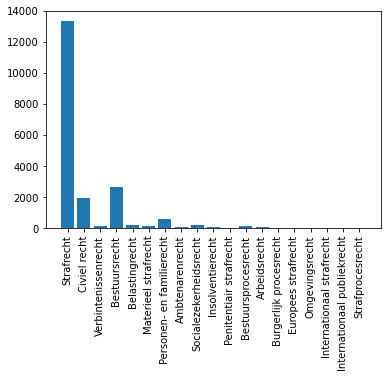

In [83]:
jurisdiction_types_dict = {
    "Strafrecht": 0,
    "Civiel recht": 0,
    "Verbintenissenrecht": 0,
    "Bestuursrecht": 0,
    "Belastingrecht": 0,
    "Materieel strafrecht": 0,
    "Civiel recht": 0,
    "Personen- en familierecht": 0,
    "Ambtenarenrecht": 0,
    "Socialezekerheidsrecht": 0,
    "Insolventierecht": 0,
    "Penitentiair strafrecht": 0,
    "Bestuursprocesrecht": 0,
    "Arbeidsrecht": 0,
    "Burgerlijk procesrecht": 0,
    "Europees strafrecht": 0,
    "Omgevingsrecht": 0,
    "Internationaal strafrecht": 0,
    "Internationaal publiekrecht": 0,
    "Strafprocesrecht": 0
}

# print(cleaned_df.jurisdiction_type.unique())
for i in range(len(cleaned_df)):
    curr = cleaned_df.iloc[i]
    for j in jurisdiction_types_dict.keys():
        if j in curr['jurisdiction_type']:
            jurisdiction_types_dict[j] = jurisdiction_types_dict[j] + 1

plt.bar(range(len(jurisdiction_types_dict)), list(jurisdiction_types_dict.values()), align='center')
plt.xticks(range(len(jurisdiction_types_dict)), list(jurisdiction_types_dict.keys()))
plt.xticks(rotation=90)

Text(0.5, 1.0, 'Verdict type counts')

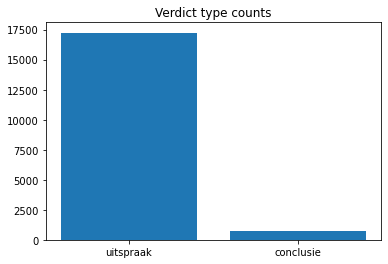

In [89]:
verdict_types = cleaned_df.verdict_type.unique()
verdict_types_counts = [cleaned_df['verdict_type'].value_counts()[0], cleaned_df['verdict_type'].value_counts()[1]]

plt.bar(verdict_types, verdict_types_counts)
plt.title('Verdict type counts')


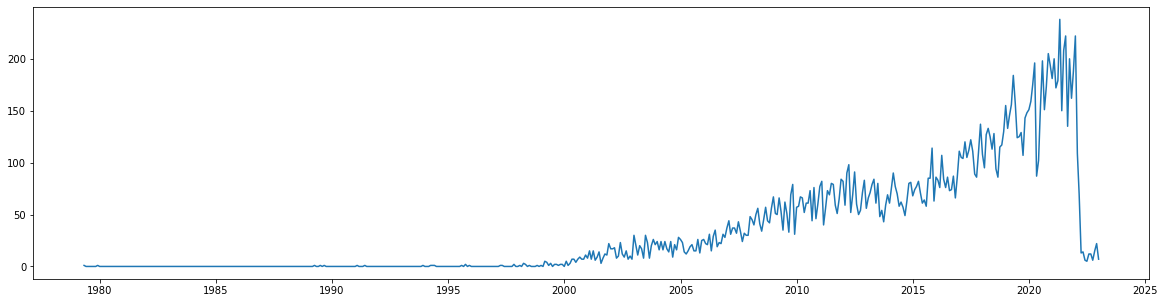

In [143]:
plt.rcParams["figure.figsize"] = (20,5)

cleaned_df_date_plot = cleaned_df["verdict_date"].value_counts().resample("1M").sum()
plt.plot(cleaned_df_date_plot)

In [140]:
print(cleaned_df["verdict_date"].value_counts())

2019-10-17    29
2017-11-16    26
2021-04-22    24
2021-11-23    23
2020-03-12    23
              ..
2008-04-18     1
2008-06-08     1
2006-02-06     1
2008-07-12     1
2011-06-17     1
Name: verdict_date, Length: 4213, dtype: int64


### Filter for trafficking keywords

In [26]:
print(f"Original case count: {len(cleaned_df)}")

trafficking_df = pd.DataFrame()
# trafficking_words = ["smokkel", "transport", "invoer", "import", "export", " uitvoer "]
trafficking_words = ["smokkel", "transport", "invoer", "import", "export"]

# trafficking_words = ["smokkel", "transport"]


for i in range(len(cleaned_df)):
    curr = cleaned_df.iloc[i]
    if any(x in curr["case text"] for x in trafficking_words):
        trafficking_df = trafficking_df.append(curr)
    
print(f"Filtered for trafficking:  {len(trafficking_df)} articles.")

Original case count: 17968
Filtered for trafficking:  3818 articles.


In [133]:
print(trafficking_df)

                                               case text  \
1      RECHTBANK ZUTPHEN Meervoudige economische stra...   
5      RECHTBANK AMSTERDAM Afdeling privaatrecht zaak...   
13     Zaaknummer: H 136/19 Parketnummer: 500.00094/1...   
14     Zaaknummer: H 135/19 Parketnummer: 500.00093/1...   
15     Parketnummer: 500.00072/18 Uitspraak: 29 juni ...   
...                                                  ...   
17963  RECHTBANK AMSTERDAM VONNIS 13/529106-06 (zaak ...   
17964  PROCUREUR-GENERAAL BIJ DE HOGE RAAD DER NEDERL...   
17965  parketnummer: 23-001217-13 datum uitspraak: 29...   
17966  RECHTBANK AMSTERDAM VONNIS 13/529144-06 (zaak ...   
17967  arrestnummer: parketnummer: 23-001835-04 datum...   

                              id jurisdiction_type publication_date  \
1      ECLI-NL-RBZUT-2003-AH9598    ['Strafrecht']       2003-09-07   
5        ECLI-NL-RBAMS-2021-1756  ['Civiel recht']       2021-04-26   
13       ECLI-NL-OGHACMB-2020-78    ['Strafrecht']       2020-04-2

In [27]:
def get_links(df):
    link_list = []
    for i in range(len(df)):
        curr = df.iloc[i]
        link = complete_case_url + curr['id'].replace('-', ':')
        link_list.append(link)
    print(link_list)

In [28]:
get_links(trafficking_df)

['https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:RBZUT:2003:AH9598', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:RBAMS:2021:1756', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGHACMB:2020:78', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGHACMB:2020:82', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGEAC:2018:352', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGEAC:2018:353', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGHACMB:2017:257', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:HR:2007:BA1113', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:PHR:2007:BA1113', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGEAC:2018:354', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:GHAMS:2018:2662', 'https://uitspraken.rechtspraak.nl/inziendocument?id=ECLI:NL:OGHACMB:2018:276', 'https://uitspraken.rechtspraak.nl/inziendocument?i

### TF-IDF / K means

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import numpy as np

documents = trafficking_df["case text"]
total_stop_words = stopwords.words('dutch') + stopwords.words('english')
# vectorizer = TfidfVectorizer(max_df=0.20, min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)
vectorizer = TfidfVectorizer(min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)


X = vectorizer.fit_transform(documents)
X = X.astype('float32')

Create elbow curve to determine best k value

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


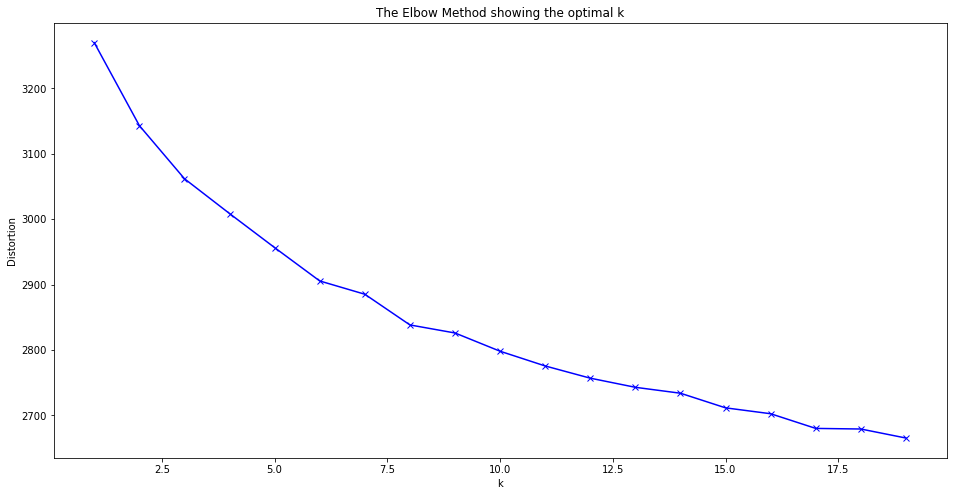

In [36]:
distortions = []
K = range(1,20)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

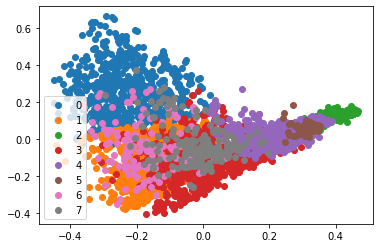

In [38]:
true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200)

labels = model.fit_predict(X)
trafficking_df["K means cluster"] = labels

X_array = X.toarray()
pca = PCA(n_components=2).fit(X_array)
XPCA = pca.transform(X_array)

u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(XPCA[labels == i , 0] , XPCA[labels == i , 1] , label = i)
plt.legend()
plt.show()

In [39]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
terms_df = pd.DataFrame()
for i in range(true_k):
    curr = []
    for ind in order_centroids[i, :19]:
        curr.append(terms[ind])
    terms_df[i] = curr

print(terms_df)

print(trafficking_df["K means cluster"].value_counts())

Top terms per cluster:
                 0               1                     2               3  \
0    medeverdachte       verdachte                 eiser       verdachte   
1        verdachte       rechtbank            verweerder             hof   
2             naam         cocaïne               besluit      betrokkene   
3        rechtbank            feit                eisers          beroep   
4              uur   medeverdachte             rechtbank   medeverdachte   
5           pagina         bewezen              gedaagde         cocaïne   
6   telefoonnummer             ten               artikel           hoger   
7          verbaal            naam                beroep             ten   
8          cocaïne        opiumwet             criterium         getuige   
9           proces        officier           gemachtigde          arrest   
10            zegt           laste                   awb         artikel   
11     organisatie        justitie            coffeeshop         

### 

### 

# Dutch News Articles

### Import Data

In [41]:
nos_df = pd.read_csv('./NOS articles/dutch-news-articles.csv')
nos_df["datetime"] = pd.to_datetime(nos_df["datetime"])

In [42]:
print(nos_df["category"].unique())

['Buitenland' 'Binnenland' 'Politiek' 'Economie' 'Koningshuis'
 'Opmerkelijk' 'Tech' 'Cultuur & Media' 'Regionaal nieuws']


Text(0, 0.5, 'Article count')

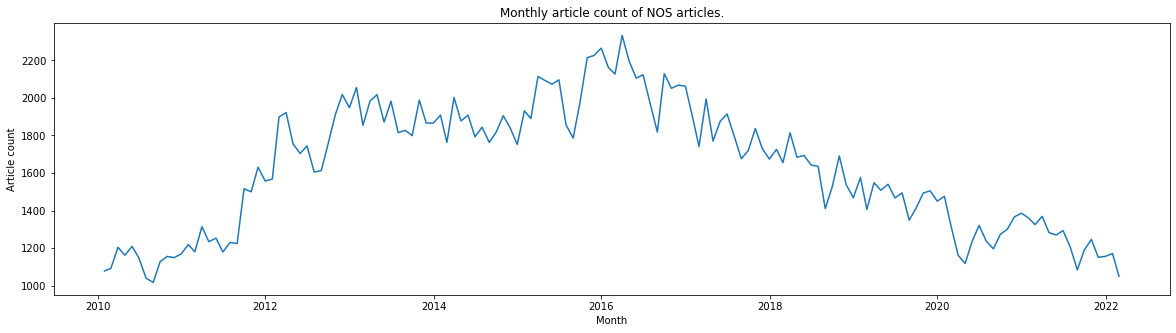

In [120]:
plt.rcParams["figure.figsize"] = (20,5)

nos_date_plot = nos_df["datetime"].value_counts().resample("1M").sum()
plt.plot(nos_date_plot[:-1])
plt.title("Monthly article count of NOS articles.")
plt.xlabel('Month')
plt.ylabel('Article count')

### Clean data

In [44]:
print(f"{len(nos_df)} articles")

word_count = 0
for i in range(len(nos_df)):
    curr = nos_df.iloc[i]
    word_count += len(curr["content"].split())
print(word_count)


237344 articles
58947842


In [45]:
cleaned_nos_df = nos_df.copy()
cleaned_nos_df['content'] = cleaned_nos_df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in dutch_stopwords]))


In [46]:
cleaned_word_count = 0
for i in range(len(cleaned_nos_df)):
    curr = cleaned_nos_df.iloc[i]
    cleaned_word_count += len(curr["content"].split())
print(cleaned_word_count)

34967964


In [48]:
print(f"Original count: {word_count} \n Cleaned count: {cleaned_word_count} \n Difference: {word_count - cleaned_word_count}")
print(f"{round((word_count - cleaned_word_count) / word_count * 100, 2)}% decrease")


Original count: 58947842 
 Cleaned count: 34967964 
 Difference: 23979878
40.68% decrease


### Filter articles for drugs and trafficking, and extract country

In [49]:
print(f"Original NOS dataframe contains {len(cleaned_nos_df)} articles.")

nos_drugs_df = pd.DataFrame()
drugs_words = ["drugs", "narcotica", "verdovende middelen"]

for i in range(len(cleaned_nos_df)):
    curr = cleaned_nos_df.iloc[i]
    if any(x in curr["content"] for x in drugs_words):
        nos_drugs_df = nos_drugs_df.append(curr)
        
print(f"Filtered for drugs: {len(nos_drugs_df)} articles")

Original NOS dataframe contains 237344 articles.
Filtered for drugs: 6503 articles


In [124]:
country = []
countries_df = pd.read_csv('dutch-countries.csv', encoding = "ISO-8859-1")
countries_list = list(countries_df["Countries"])
countries_list.extend(["Londen", "Belgisch", "Rio", "Russische", "Colorado", "Saudi-Arabië", "Manchester", "Groot-Brittannië", "Britse", "Deense", "Mexicaanse", "Braziliaanse", "Surinaamse", "Amerika", "Franse", "Spaanse", "Trinidad", "Amerikaanse", "Los Angeles", "Italiaanse", "Trinidad en Tobago"])

for i in range(len(nos_drugs_df)):
    curr = nos_drugs_df.iloc[i]
    text = curr.content.replace("ë", "ë")
    countries_in_content = []
    if curr["category"] == "Buitenland":
        countries_in_content = [(text.find(c), c) for c in countries_list if c in text]
        if len(countries_in_content) > 0:
            result = min(countries_in_content)[1]
            if result in {"Amerika", "Amerikaanse", "Los Angeles", "Colorado"}:
                country.append("Verenigde Staten")
            elif result == "Franse":
                country.append("Frankrijk")
            elif result == "Spaanse":
                country.append("Spanje")
            elif result == "Italiaanse":
                country.append("Italië")
            elif result == "Trinidad":
                country.append("Trinidad en Tobago")
            elif result == "Mexicaanse":
                country.append("Mexico")
            elif result == "Surinaamse":
                country.append("Suriname")
            elif result in {"Londen", "Brits", "Groot-Brittannië", "Manchester"}:
                country.append("Verenigd Koninkrijk")
            elif result in {"Braziliaanse", "Rio"}:
                country.append("Brazilië")
            elif result == "Deense":
                country.append("Denemarken")
            elif result == "Belgisch":
                country.append("België")
            elif result == "Russische":
                country.append("Rusland")
            else:
                country.append(min(countries_in_content)[1])
        else:
            country.append("unknown")
    else:
        country.append("Nederland")
            
nos_drugs_df["country"] = country

217


In [121]:
print(f"Original article count: {len(nos_df)} \n Filtered for drugs: {len(nos_drugs_df)}")

nos_trafficking_df = pd.DataFrame()
trafficking_words = ["smokkel", "transport", "invoer", "import", "export", "uitvoer"]

for i in range(len(nos_drugs_df)):
    curr = nos_drugs_df.iloc[i]
    if any(x in curr["content"] for x in trafficking_words):
        nos_trafficking_df = nos_trafficking_df.append(curr)
    
print(f"Filtered for trafficking:  {len(nos_trafficking_df)} articles.")

Original article count: 237344 
 Filtered for drugs: 6503
Filtered for trafficking:  1396 articles.


In [122]:
print(f"Original article count: {len(nos_df)} \n Filtered for drugs: {len(nos_drugs_df)}")

nos_trafficking_df = pd.DataFrame()
trafficking_words = ["smokkel", "transport", "invoer", "import", "export"]

for i in range(len(nos_drugs_df)):
    curr = nos_drugs_df.iloc[i]
    if any(x in curr["content"] for x in trafficking_words):
        nos_trafficking_df = nos_trafficking_df.append(curr)
    
print(f"Filtered for trafficking:  {len(nos_trafficking_df)} articles.")

Original article count: 237344 
 Filtered for drugs: 6503
Filtered for trafficking:  1275 articles.


In [126]:
print(len(nos_trafficking_df['country'].value_counts().index.tolist()))
nos_trafficking_df['country'].value_counts().index.tolist()


75


['Nederland',
 'Mexico',
 'Verenigde Staten',
 'Suriname',
 'Colombia',
 'Spanje',
 'Italië',
 'Indonesië',
 'Australië',
 'Venezuela',
 'Brazilië',
 'Britse',
 'België',
 'Frankrijk',
 'Filipijnen',
 'China',
 'Iran',
 'Thailand',
 'Guatemala',
 'Afghanistan',
 'Oostenrijk',
 'Vietnam',
 'Nicaragua',
 'Honduras',
 'Rusland',
 'Saudi-Arabië',
 'Verenigd Koninkrijk',
 'Libië',
 'unknown',
 'Libanon',
 'Griekenland',
 'Zweden',
 'Noord-Korea',
 'Syrië',
 'Peru',
 'Israël',
 'Bulgarije',
 'Jamaica',
 'Ecuador',
 'Mali',
 'Sri Lanka',
 'Guyana',
 'Somalië',
 'Niger',
 'Chili',
 'El Salvador',
 'Egypte',
 'Montenegro',
 'Vaticaanstad',
 'Litouwen',
 'Pakistan',
 'Paraguay',
 'Trinidad en Tobago',
 'Canada',
 'Cuba',
 'Panama',
 'Kosovo',
 'Argentinië',
 'India',
 'Albanië',
 'Kaapverdië',
 'Irak',
 'Turkije',
 'Uruguay',
 'Marshalleilanden',
 'Zwitserland',
 'Polen',
 'Denemarken',
 'Slovenië',
 'Kenia',
 'Servië',
 'Noorwegen',
 'Nieuw-Zeeland',
 'Zuid-Afrika',
 'Dominica']

In [55]:
print(nos_trafficking_df[nos_trafficking_df["country"] == "Spanje"])

          category                                            content country  \
7233    Buitenland  In Spanje drugsbende opgerold hasj smokkelde v...  Spanje   
9520    Buitenland  De Spaanse politie twee Nederlandse mannen 45 ...  Spanje   
21433   Buitenland  De Spaanse politie drugsbende opgerold drugs s...  Spanje   
27928   Buitenland  De Spaanse politie bende opgerold kleine kinde...  Spanje   
46139   Buitenland  Onder noemer 'Operación Emperador' (operatie ...  Spanje   
86316   Buitenland  De Spaanse politie meest gezochte criminelen C...  Spanje   
88878   Buitenland  Spanje bijna 700 waardevolle archeologische vo...  Spanje   
90374   Buitenland  De Spaanse politie 13.000 kilo hasj beslag gen...  Spanje   
97562   Buitenland  De Spaanse politie vanochtend vier jihadisten ...  Spanje   
112847  Buitenland  Voor Zuid-Spaanse kust weekend Nederlandse zei...  Spanje   
113145  Buitenland  De Spaanse politie grote antidrugsactie opnieu...  Spanje   
143399  Buitenland  De Spaan

### TF IDF

Prepare data

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

print(len(nos_trafficking_df))
documents = nos_trafficking_df["content"]
# total_stop_words = stopwords.words('dutch') + stopwords.words('english')
# vectorizer = TfidfVectorizer(max_df=0.20, min_df=10, stop_words=total_stop_words , use_idf=True,  lowercase=True)
vectorizer = TfidfVectorizer(use_idf=True,  lowercase=True)

X = vectorizer.fit_transform(documents)
print(X)
# X = X.astype('float32')

1275
  (0, 6682)	0.09214293159161856
  (0, 2335)	0.1848805434856492
  (0, 20442)	0.09034552761060739
  (0, 12599)	0.11915053305763011
  (0, 5310)	0.07684807128037202
  (0, 5965)	0.07684807128037202
  (0, 19617)	0.12428766757982002
  (0, 10314)	0.12337138738498353
  (0, 18858)	0.07592883015130447
  (0, 5750)	0.09724052958162376
  (0, 20766)	0.13596293854363128
  (0, 21946)	0.1797451187691817
  (0, 5806)	0.1848805434856492
  (0, 18820)	0.20102746221552786
  (0, 2117)	0.10607168201297551
  (0, 2633)	0.21384399263966178
  (0, 12764)	0.09458908172590992
  (0, 17508)	0.09334235013616946
  (0, 6549)	0.14439092483938126
  (0, 8525)	0.04433939943269571
  (0, 5424)	0.09282273098251612
  (0, 4708)	0.17911745873952153
  (0, 21147)	0.11371844037628355
  (0, 4870)	0.08238397178362361
  (0, 9531)	0.04934818597576641
  :	:
  (1274, 22049)	0.027398612058098556
  (1274, 8107)	0.04097067058059806
  (1274, 6798)	0.042060582318850154
  (1274, 18877)	0.07751266471776641
  (1274, 21447)	0.026512307979695275


Elbow curve

Text(0.5, 1.0, 'Elbow curve')

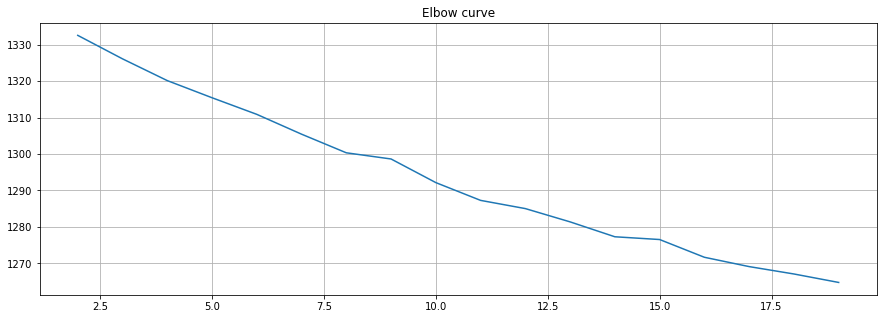

In [57]:
distorsions = []
k_range = 20
for k in range(2, k_range):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200)
    kmeans.fit_predict(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, k_range), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Text(0.5, 1.0, 'Elbow curve')

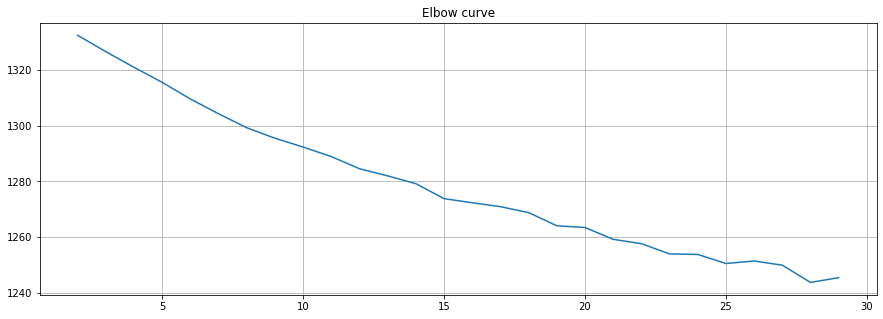

In [58]:
distorsions = []
k_range = 30
for k in range(2, k_range):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200)
    kmeans.fit_predict(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, k_range), distorsions)
plt.grid(True)
plt.title('Elbow curve')

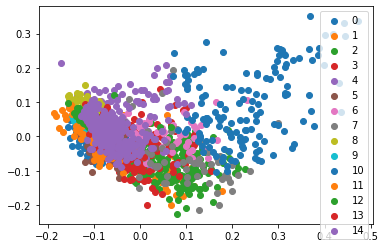

In [59]:
true_k = 15
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200)

labels = model.fit_predict(X)
nos_trafficking_df["K means cluster"] = labels

X_array = X.toarray()
pca = PCA(n_components=2).fit(X_array)
XPCA = pca.transform(X_array)

u_labels = np.unique(labels)
for i in u_labels:
    plt.scatter(XPCA[labels == i , 0] , XPCA[labels == i , 1] , label = i)
plt.legend()
plt.show()

In [60]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
terms_df = pd.DataFrame()
for i in range(true_k):
    curr = []
    for ind in order_centroids[i, :19]:
        curr.append(terms[ind])
    terms_df[i] = curr

print(terms_df)

print(nos_trafficking_df["K means cluster"].value_counts())

Top terms per cluster:
              0              1            2            3              4   \
0      indonesie        politie           de           de             we   
1      australie             de      politie         jaar        politie   
2       executie     verdachten        drugs    rechtbank             de   
3      doodstraf            oss           ne           om     criminelen   
4             rs      criminele         kilo          hij           zegt   
5      xecuteerd        martien          man          cel            het   
6             de  woonwagenkamp        cocai          het           geld   
7   australische           twee         twee     justitie      berichten   
8   indonesische         beslag       werden     openbaar      nederland   
9         widodo          groep     opgepakt  veroordeeld            dat   
10     president         werden           in   ministerie           gaat   
11         china           geld        heroi    nederland        

# 